In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn theme for aesthetics
sns.set(style="whitegrid")

# lexicon-based sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# lexicon-based emotion analysis
from nrclex import NRCLex

# transformer-based sentiment and emotion analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from transformers import pipeline

# 1. Dataset

In [2]:
feedback=pd.DataFrame({'comments':["The staff were helpful and kind throughout my visit.",
                                   "This is the worst experience I’ve ever had with a bank.",
                                   "The process was smooth, but the wait time was ridiculous.",
                                   "I guess waiting 45 minutes for a form is considered efficient now.",
                                   "Excellent service, quick resolution of my issue.",
                                   "The representative was rude and didn’t care at all.",
                                   "Not bad, but not great either. Just okay.",
                                   "I love how unprofessional they are. Really top-notch sarcasm.",
                                   "Got what I needed after several follow-ups and escalations.",
                                   "Amazing how they lost my documents twice and didn’t apologize.",
                                   "Thank you for resolving my complaint quickly. Much appreciated.",
                                   "Your app keeps crashing. Fix it.",
                                   "Nothing special, just another visit.",
                                   "They said they'd call me back. They didn’t. Shocking.",
                                   "Great interface, but too many bugs.",
                                   "I waited for an hour, then they told me to come tomorrow.",
                                   "Meh. It worked, I guess.",
                                   "The manager listened and helped me out personally. Impressed.",
                                   "Their 'priority service' means you wait just as long. Nice.",
                                   "Problem solved! Thanks a ton. Really efficient team."],
                      'sentiment':['positive','negative','neutral','negative','positive','negative','neutral',
                                  'negative','neutral','negative','positive','negative','neutral','negative',
                                  'neutral','negative','neutral','positive','negative','positive']})
feedback

,comments,sentiment
0,The staff were helpful and kind throughout my ...,positive
1,This is the worst experience I’ve ever had wit...,negative
2,"The process was smooth, but the wait time was ...",neutral
3,I guess waiting 45 minutes for a form is consi...,negative
4,"Excellent service, quick resolution of my issue.",positive
5,The representative was rude and didn’t care at...,negative
6,"Not bad, but not great either. Just okay.",neutral
7,I love how unprofessional they are. Really top...,negative
8,Got what I needed after several follow-ups and...,neutral
9,Amazing how they lost my documents twice and d...,negative


In [3]:
feedback['sentiment'].value_counts()

sentiment
negative    9
neutral     6
positive    5
Name: count, dtype: int64

# 2. Sentiment analysis -- with lexicon-based models

## 2.1. TextBlob

In [4]:
def textblob_sentiment(text):
    blob=TextBlob(text)
    return blob.sentiment.polarity

# just taking into account the polarity score, and not the subjectivity score
# polarity score lies in the range [-1,1]
# we have [-1,-0.1) be negative, [-0.1,0.1] be neutral, and (0.1,1] be positive

feedback[['tb_polarity']]=feedback['comments'].apply(
    lambda x: pd.Series(textblob_sentiment(x)))

# allotting label of negative, neutral, and positive to each
def label_from_polarity(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

feedback['tb_sentiment']=feedback['tb_polarity'].apply(label_from_polarity)
feedback

,comments,sentiment,tb_polarity,tb_sentiment
0,The staff were helpful and kind throughout my ...,positive,0.600000,positive
1,This is the worst experience I’ve ever had wit...,negative,-1.000000,negative
2,"The process was smooth, but the wait time was ...",neutral,0.033333,neutral
3,I guess waiting 45 minutes for a form is consi...,negative,0.000000,neutral
4,"Excellent service, quick resolution of my issue.",positive,0.666667,positive
5,The representative was rude and didn’t care at...,negative,-0.300000,negative
6,"Not bad, but not great either. Just okay.",neutral,0.150000,positive
7,I love how unprofessional they are. Really top...,negative,0.750000,positive
8,Got what I needed after several follow-ups and...,neutral,0.000000,neutral
9,Amazing how they lost my documents twice and d...,negative,0.600000,positive


## 2.2. VADER

In [5]:
analyser=SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyser.polarity_scores(text)['compound']

feedback['vader_compound']=feedback['comments'].apply(vader_sentiment)

# based on the compound score calculated, identifying the sentiment with the same range
def label_from_vader(score):
    if score >= 0.01:
        return 'positive'
    elif score <= -0.01:
        return 'negative'
    else:
        return 'neutral'

feedback['vader_sentiment']=feedback['vader_compound'].apply(label_from_vader)
feedback

,comments,sentiment,tb_polarity,tb_sentiment,vader_compound,vader_sentiment
0,The staff were helpful and kind throughout my ...,positive,0.600000,positive,0.7351,positive
1,This is the worst experience I’ve ever had wit...,negative,-1.000000,negative,-0.6249,negative
2,"The process was smooth, but the wait time was ...",neutral,0.033333,neutral,-0.5023,negative
3,I guess waiting 45 minutes for a form is consi...,negative,0.000000,neutral,0.4215,positive
4,"Excellent service, quick resolution of my issue.",positive,0.666667,positive,0.5719,positive
5,The representative was rude and didn’t care at...,negative,-0.300000,negative,0.0516,positive
6,"Not bad, but not great either. Just okay.",neutral,0.150000,positive,-0.2883,negative
7,I love how unprofessional they are. Really top...,negative,0.750000,positive,-0.0717,negative
8,Got what I needed after several follow-ups and...,neutral,0.000000,neutral,0.0000,neutral
9,Amazing how they lost my documents twice and d...,negative,0.600000,positive,0.4404,positive


In [9]:
feedback['vader_sentiment'].value_counts()

vader_sentiment
positive    10
negative     7
neutral      3
Name: count, dtype: int64

# 3. Sentiment analysis -- with transformer-based models

## 3.1. Twitter-RoBERTa

In [6]:
# Load model
model_name="cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)

# Define sentiment labels
labels=['negative', 'neutral', 'positive']

In [7]:
# sentiment prediction function

def get_sentiment(text):
    # Preprocessing (very light)
    text=text.strip().lower()
    inputs=tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs=model(**inputs)
    scores=outputs.logits.softmax(dim=1).squeeze()
    predicted_class=scores.argmax().item()
    return labels[predicted_class]

feedback['roberta_sentiment']=feedback['comments'].apply(get_sentiment)

In [8]:
feedback['roberta_sentiment'].value_counts()

roberta_sentiment
positive    8
negative    7
neutral     5
Name: count, dtype: int64

# 4. Graphing to compare the models

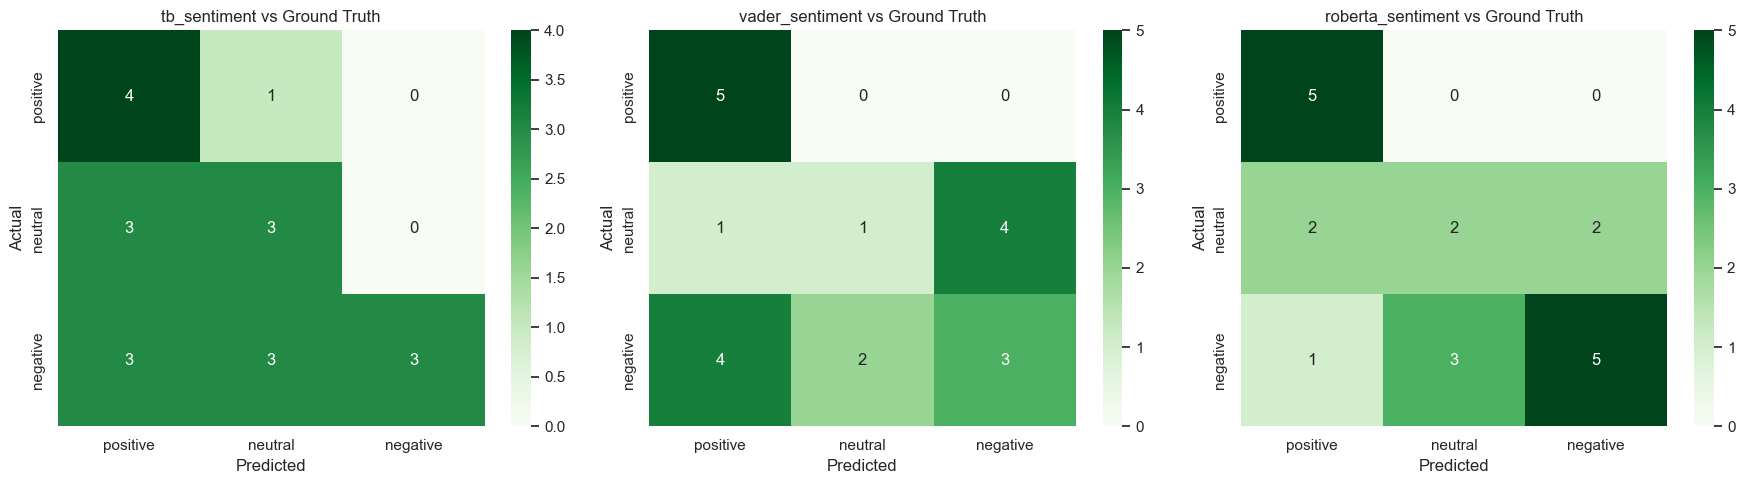

In [9]:
from sklearn.metrics import confusion_matrix

models = ['tb_sentiment', 'vader_sentiment', 'roberta_sentiment']
true_labels = feedback['sentiment']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(models):
    cm = confusion_matrix(true_labels, feedback[model], labels=['positive', 'neutral', 'negative'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['positive', 'neutral', 'negative'],
                yticklabels=['positive', 'neutral', 'negative'],
                ax=axes[i])
    axes[i].set_title(f'{model} vs Ground Truth')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

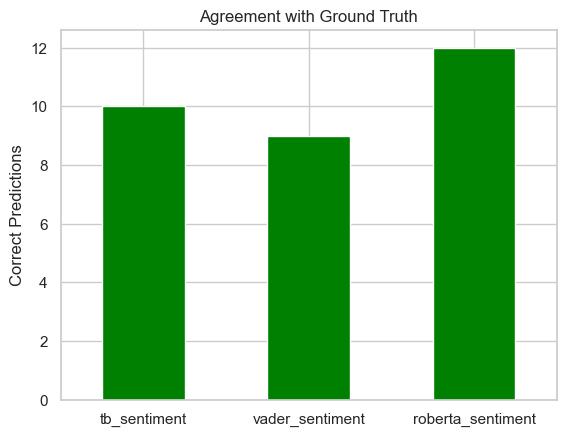

In [10]:
matches = {model: (feedback[model] == feedback['sentiment']).sum() for model in models}
pd.Series(matches).plot(kind='bar', color='green')
plt.title('Agreement with Ground Truth')
plt.ylabel('Correct Predictions')
plt.xticks(rotation=0)
plt.show()

In [11]:
# twitter roberta has performed the best amongst the 3

# however, textblob works well, too!
# 10 correct by textblob
# 9 correct by vader
# 12 correct by twitter roberta

# thus, it seems that for short and well-written texts (formally presented, with no use of social media txt

# 5. Testing with a noisier dataset

In [38]:
noisy_feedback= pd.DataFrame({
    'comments': ["Da staf was soooooo helpful 🙏💯 ty @branch_mgr!",
                 "wOrSt exp evr!! 👎 nevr goin 2 dis bank again 🤬",
                 "smooth process... bt d wait??? ughhhh, 1hr+ 😩",
                 "so 45 mins for ONE form?? lol wow. #efficient 🤡",
                 "Xclnt svc 👏 issue solved fast af!! tysm!!",
                 "Rep wz rlly rude 😑 didn't even LISTEN!! #badexp",
                 "not bad... not gr8 either. meh. 🤷",
                 "gotta love how 'pro' they r 🤣 sarcasm ON 🔥",
                 "had 2 follow-up like 5 times 😤 finally got it done",
                 "LOL they LOST my docs TWICE & said 'oops' 🤦",
                 "Big thanks 4 resolving my query super fast 🙌🔥",
                 "ur app is TRASH. keeps crashing bruh 🤯 #fixit",
                 "just another meh visit. nthng to say.",
                 "they said 'we’ll call back' but nada. classic. 🙄",
                 "UI is nice... bugs r WILD tho 😤 #glitchcity",
                 "1hr wait then 'come tmrw'. wat a joke 😤🤬",
                 "meh. worked... I guess?",
                 "Mgr actually helped 1-1 🙌 really appreciated that!",
                 "'Priority service' = same long wait. smh 😑",
                  "Prob solved 🚀 team was 💪 fast & pro!"],
    'sentiment': ['positive','negative','neutral','negative','positive','negative','neutral',
                  'negative','neutral','negative','positive','negative','neutral','negative',
                  'neutral','negative','neutral','positive','negative','positive']})
noisy_feedback

,comments,sentiment
0,Da staf was soooooo helpful 🙏💯 ty @branch_mgr!,positive
1,wOrSt exp evr!! 👎 nevr goin 2 dis bank again 🤬,negative
2,"smooth process... bt d wait??? ughhhh, 1hr+ 😩",neutral
3,so 45 mins for ONE form?? lol wow. #efficient 🤡,negative
4,Xclnt svc 👏 issue solved fast af!! tysm!!,positive
5,Rep wz rlly rude 😑 didn't even LISTEN!! #badexp,negative
6,not bad... not gr8 either. meh. 🤷,neutral
7,gotta love how 'pro' they r 🤣 sarcasm ON 🔥,negative
8,had 2 follow-up like 5 times 😤 finally got it ...,neutral
9,LOL they LOST my docs TWICE & said 'oops' 🤦,negative


In [41]:
def textblob_sentiment(text):
    blob=TextBlob(text)
    return blob.sentiment.polarity

# just taking into account the polarity score, and not the subjectivity score
# polarity score lies in the range [-1,1]
# we have [-1,-0.1) be negative, [-0.1,0.1] be neutral, and (0.1,1] be positive

noisy_feedback[['tb_polarity']]=noisy_feedback['comments'].apply(lambda x: pd.Series(textblob_sentiment(x)))

# allotting label of negative, neutral, and positive to each
def label_from_polarity(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

noisy_feedback['tb_sentiment']=noisy_feedback['tb_polarity'].apply(label_from_polarity)

In [42]:
analyser=SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyser.polarity_scores(text)['compound']

noisy_feedback['vader_compound']=noisy_feedback['comments'].apply(vader_sentiment)

# based on the compound score calculated, identifying the sentiment with the same range
def label_from_vader(score):
    if score >= 0.01:
        return 'positive'
    elif score <= -0.01:
        return 'negative'
    else:
        return 'neutral'

noisy_feedback['vader_sentiment']=noisy_feedback['vader_compound'].apply(label_from_vader)

In [45]:
# Load model
model_name="cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)

# Define sentiment labels
labels=['negative', 'neutral', 'positive']

# sentiment prediction function

def get_sentiment(text):
    # Preprocessing (very light)
    text=text.strip().lower()
    inputs=tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs=model(**inputs)
    scores=outputs.logits.softmax(dim=1).squeeze()
    predicted_class=scores.argmax().item()
    return labels[predicted_class]

noisy_feedback['roberta_sentiment']=noisy_feedback['comments'].apply(get_sentiment)
noisy_feedback

,comments,sentiment,tb_polarity,tb_sentiment,vader_compound,vader_sentiment,roberta_sentiment
0,Da staf was soooooo helpful 🙏💯 ty @branch_mgr!,positive,0.000000,neutral,0.6900,positive,positive
1,wOrSt exp evr!! 👎 nevr goin 2 dis bank again 🤬,negative,-1.000000,negative,-0.6892,negative,negative
2,"smooth process... bt d wait??? ughhhh, 1hr+ 😩",neutral,0.400000,positive,-0.3899,negative,neutral
3,so 45 mins for ONE form?? lol wow. #efficient 🤡,negative,0.450000,positive,0.8677,positive,neutral
4,Xclnt svc 👏 issue solved fast af!! tysm!!,positive,0.488281,positive,0.5053,positive,positive
5,Rep wz rlly rude 😑 didn't even LISTEN!! #badexp,negative,-0.468750,negative,-0.5550,negative,negative
6,not bad... not gr8 either. meh. 🤷,neutral,0.350000,positive,0.6758,positive,positive
7,gotta love how 'pro' they r 🤣 sarcasm ON 🔥,negative,0.500000,positive,0.6249,positive,positive
8,had 2 follow-up like 5 times 😤 finally got it ...,neutral,0.000000,neutral,0.3612,positive,positive
9,LOL they LOST my docs TWICE & said 'oops' 🤦,negative,0.800000,positive,0.1280,positive,negative


## 5.1 Graphing to compare

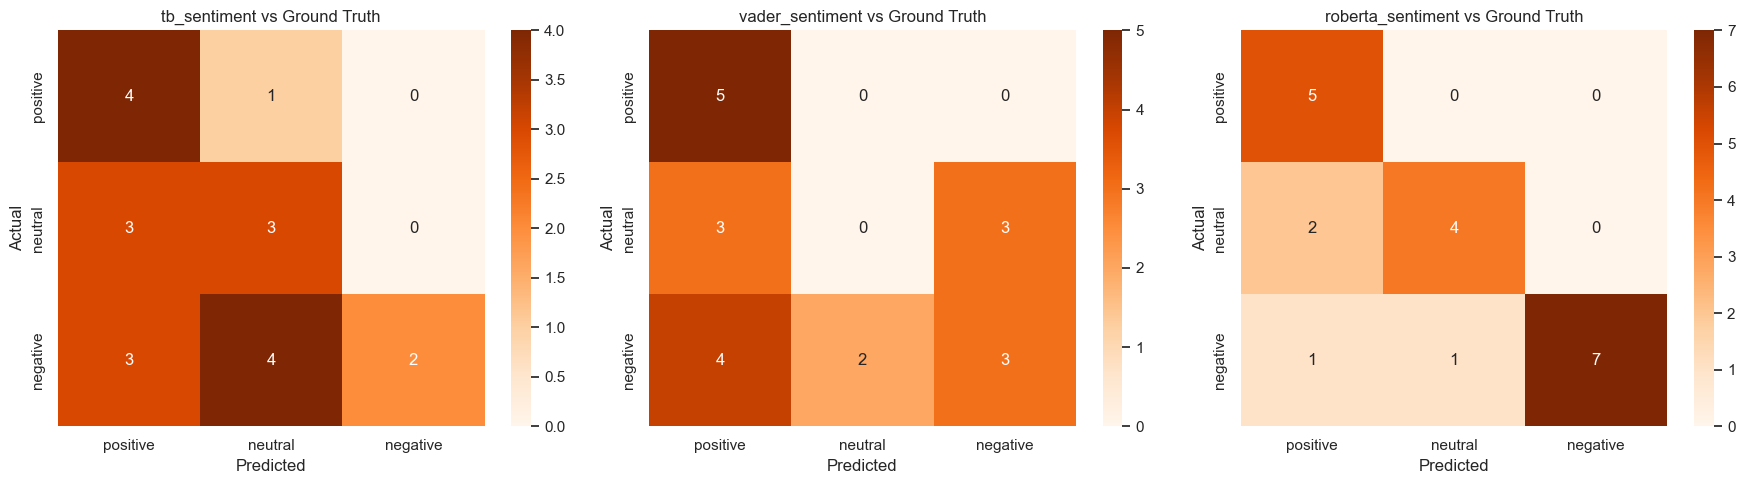

In [46]:
models = ['tb_sentiment', 'vader_sentiment', 'roberta_sentiment']
true_labels = noisy_feedback['sentiment']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(models):
    cm = confusion_matrix(true_labels, noisy_feedback[model], labels=['positive', 'neutral', 'negative'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['positive', 'neutral', 'negative'],
                yticklabels=['positive', 'neutral', 'negative'],
                ax=axes[i])
    axes[i].set_title(f'{model} vs Ground Truth')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

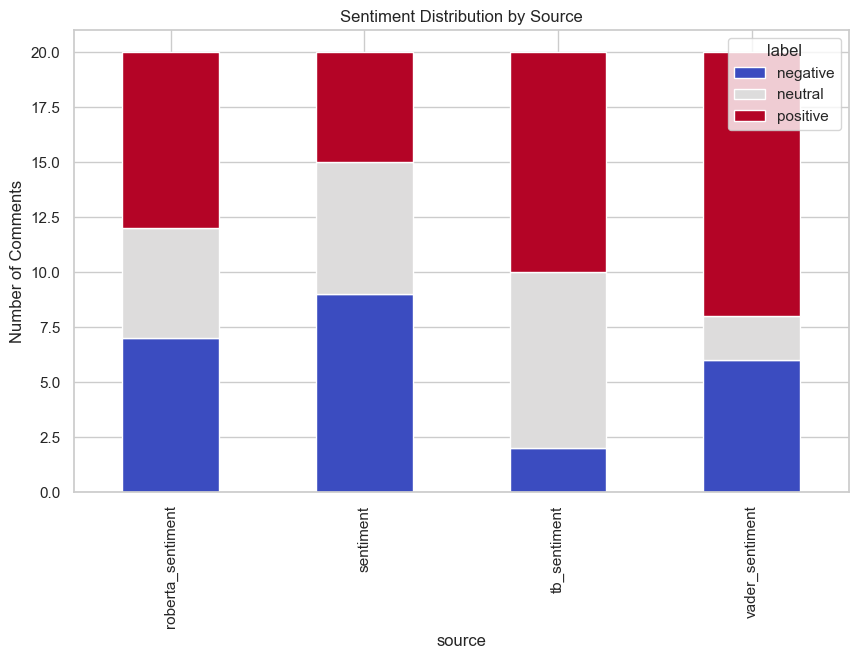

In [23]:
noisy_feedback[['sentiment', 'tb_sentiment', 'vader_sentiment', 'roberta_sentiment']].melt(var_name='source', value_name='label') \
    .groupby(['source', 'label']).size().unstack().plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10,6))
plt.title('Sentiment Distribution by Source')
plt.ylabel('Number of Comments')
plt.show()

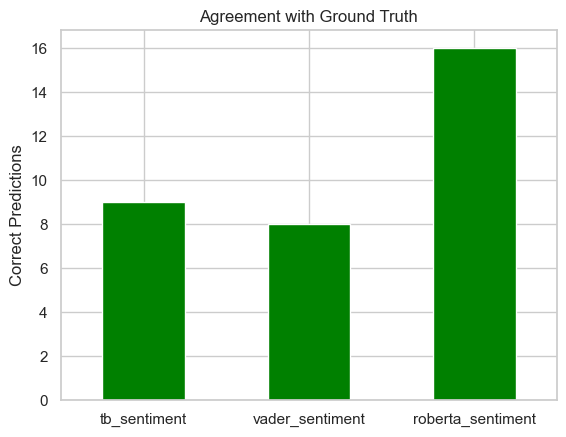

In [24]:
matches = {model: (noisy_feedback[model] == noisy_feedback['sentiment']).sum() for model in models}
pd.Series(matches).plot(kind='bar', color='green')
plt.title('Agreement with Ground Truth')
plt.ylabel('Correct Predictions')
plt.xticks(rotation=0)
plt.show()

In [25]:
# for noisy data -- like prevalent on social media and customer review websites
# misspellings + special characters + abbreviations + emoticons are dealt well with Twitter RoBERTa

# 6. Emotion analysis -- with lexicon-based models

## 6.1. NRC

In [28]:
def get_nrc_dominant_emotion(text):
    emo=NRCLex(text)
    emotions=emo.raw_emotion_scores
    if emotions:
        return max(emotions, key=emotions.get)
    else:
        return 'none'

feedback['nrc_dominant_emotion']=feedback['comments'].apply(get_nrc_dominant_emotion)

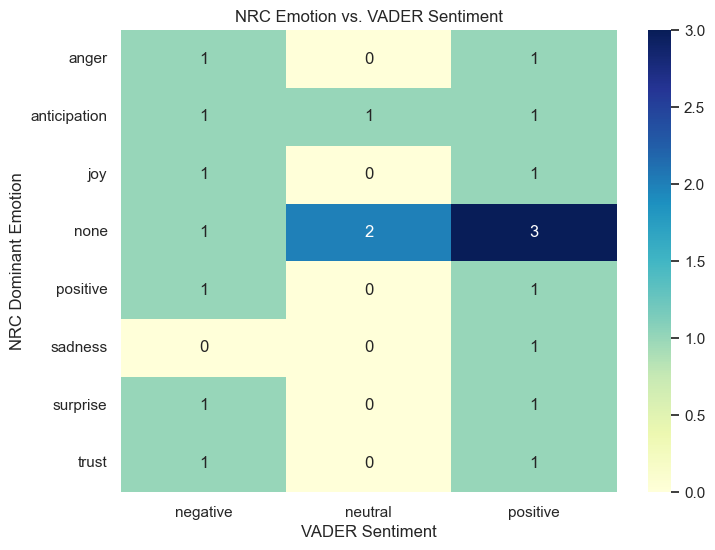

In [29]:
# Cross-tabulate NRC emotions and VADER sentiment
ct = pd.crosstab(feedback['nrc_dominant_emotion'], feedback['vader_sentiment'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('NRC Emotion vs. VADER Sentiment')
plt.xlabel('VADER Sentiment')
plt.ylabel('NRC Dominant Emotion')
plt.show()

In [73]:
# evaluating the degree of cohesion in NRC Emotion and VADER Sentiment
# we do this by evalaution whether the emotions are detected by NRC are in line with the sentiment of VADER

# in the negative column, the predicted emotions are anger, anticipation, joy, none, positive, surprise, trust
# of them, 1 joy, 1 positive, 1 trust, are incorrect.

# in the neutral column, the predicted emotions are anticipation and none
# of them, 1 anticipation is incorrect.

# in the positive column, we have anger, anticipation, none, positive, sadness, surprise, trust
# of them, 1 anger, 1, sadness are incorrect.


# overall, 14 out of 20 are incorrect -- i.e., 70% being correct

# 7. Emotion analysis -- with transformer-based models

In [30]:
# Load pre-trained GoEmotions model
model_name="bhadresh-savani/bert-base-go-emotion"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline
emotion_classifier=pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Device set to use cpu
D:\python\test\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [31]:
# Store dominant emotion list
dominant_emotions=[]

for comment in tqdm(feedback['comments']):
    result=emotion_classifier(comment)[0]
    result_sorted=sorted(result, key=lambda x: x['score'], reverse=True)
    dominant_emotions.append(result_sorted[0]['label'])

# Add to your DataFrame
feedback['bert_ge_dominant_emotion']=dominant_emotions
feedback

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.11it/s]


,comments,sentiment,tb_polarity,tb_sentiment,vader_compound,vader_sentiment,roberta_sentiment,nrc_dominant_emotion,bert_ge_dominant_emotion
0,the staff were helpful and kind throughout my ...,positive,0.600000,positive,0.7351,positive,positive,positive,neutral
1,this is the worst experience ive ever had with...,negative,-1.000000,negative,-0.6249,negative,negative,trust,disgust
2,the process was smooth but the wait time was r...,neutral,0.033333,neutral,-0.5023,negative,negative,anticipation,annoyance
3,i guess waiting minutes for a form is conside...,negative,0.000000,neutral,0.4215,positive,neutral,surprise,neutral
4,excellent service quick resolution of my issue,positive,0.666667,positive,0.5719,positive,positive,joy,admiration
5,the representative was rude and didnt care at all,negative,-0.300000,negative,-0.6836,negative,negative,none,anger
6,not bad but not great either just okay,neutral,0.150000,positive,-0.2883,negative,positive,anger,disapproval
7,i love how unprofessional they are really topn...,negative,0.350000,positive,-0.0717,negative,positive,joy,love
8,got what i needed after several followups and ...,neutral,0.000000,neutral,0.0000,neutral,neutral,none,neutral
9,amazing how they lost my documents twice and d...,negative,0.600000,positive,0.2969,positive,negative,sadness,sadness


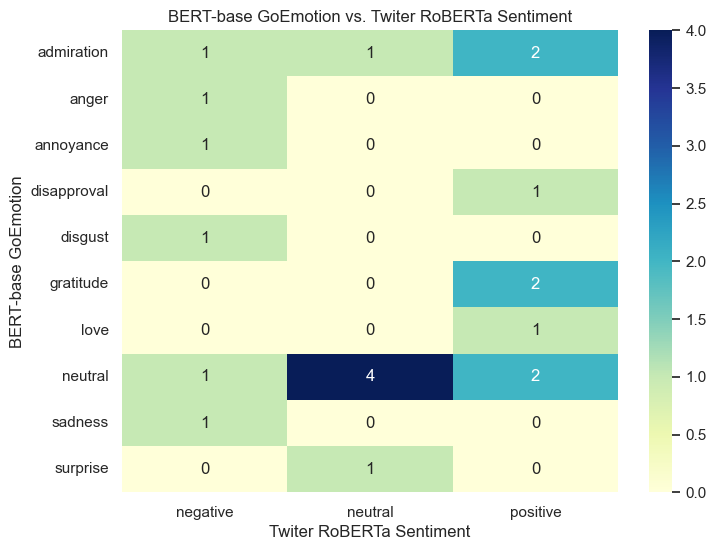

In [32]:
# Cross-tabulate NRC emotions and VADER sentiment
ct_transformer = pd.crosstab(feedback['bert_ge_dominant_emotion'], feedback['roberta_sentiment'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ct_transformer, annot=True, fmt='d', cmap='YlGnBu')
plt.title('BERT-base GoEmotion vs. Twiter RoBERTa Sentiment')
plt.xlabel('Twiter RoBERTa Sentiment')
plt.ylabel('BERT-base GoEmotion')
plt.show()

In [71]:
# evaluating the degree of cohesion in BERT-base GoEmotion and Twitter RoBERTa
# we do this by evalaution whether the emotions are detected by BERT-base GoEmotion are in line with the sentiment of Twitter RoBERTa

# in the negative column, the predicted emotions are admiration, anger, annoyance, disgust, neutral, sadness, surprise
# of them, 1 admiration is incorrect.

# in the neutral column, the predicted emotions are admiration and neutral
# of them, 1 admiration is incorrect.

# in the positive column, we have admiration, disapproval, gratitude, love, neutral
# of them, 1 disapproval is incorrect.


# overall, 17 out of 20 are incorrect -- i.e., 85% being correct

# 8. Comparing the two

In [47]:
# Set wider column display
pd.set_option('display.max_colwidth', None)  # Show full content in columns
pd.set_option('display.width', 200)          # Widen display area

feedback[['comments','nrc_dominant_emotion','bert_ge_dominant_emotion']]

,comments,nrc_dominant_emotion,bert_ge_dominant_emotion
0,the staff were helpful and kind throughout my visit,positive,neutral
1,this is the worst experience ive ever had with a bank,trust,disgust
2,the process was smooth but the wait time was ridiculous,anticipation,annoyance
3,i guess waiting minutes for a form is considered efficient now,surprise,neutral
4,excellent service quick resolution of my issue,joy,admiration
5,the representative was rude and didnt care at all,none,anger
6,not bad but not great either just okay,anger,disapproval
7,i love how unprofessional they are really topnotch sarcasm,joy,love
8,got what i needed after several followups and escalations,none,neutral
9,amazing how they lost my documents twice and didnt apologize,sadness,sadness


# 9. Applying to the noisier dataset

In [52]:
def get_nrc_dominant_emotion(text):
    emo=NRCLex(text)
    emotions=emo.raw_emotion_scores
    if emotions:
        return max(emotions, key=emotions.get)
    else:
        return 'none'

noisy_feedback['nrc_dominant_emotion']=noisy_feedback['comments'].apply(get_nrc_dominant_emotion)

In [53]:
# Load pre-trained GoEmotions model
model_name="bhadresh-savani/bert-base-go-emotion"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline
emotion_classifier=pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Store dominant emotion list
dominant_emotions=[]

for comment in tqdm(noisy_feedback['comments']):
    result=emotion_classifier(comment)[0]
    result_sorted=sorted(result, key=lambda x: x['score'], reverse=True)
    dominant_emotions.append(result_sorted[0]['label'])

# Add to your DataFrame
noisy_feedback['bert_ge_dominant_emotion']=dominant_emotions

Device set to use cpu
D:\python\test\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.67it/s]


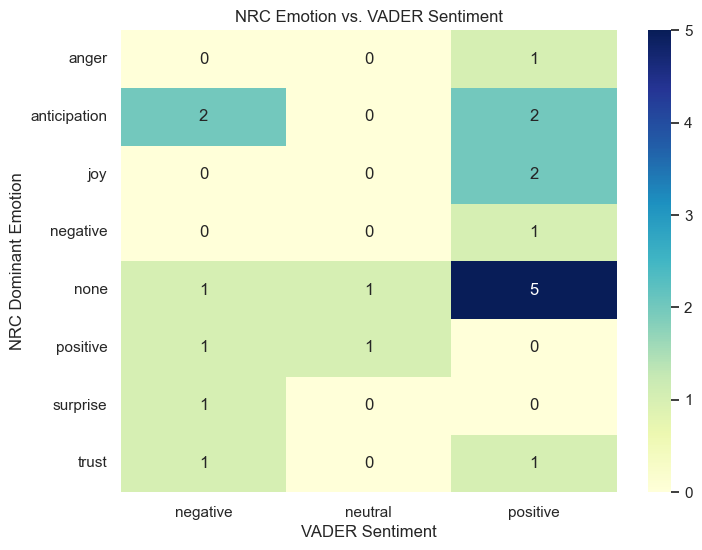

In [36]:
# Cross-tabulate NRC emotions and VADER sentiment
ct = pd.crosstab(noisy_feedback['nrc_dominant_emotion'], noisy_feedback['vader_sentiment'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('NRC Emotion vs. VADER Sentiment')
plt.xlabel('VADER Sentiment')
plt.ylabel('NRC Dominant Emotion')
plt.show()

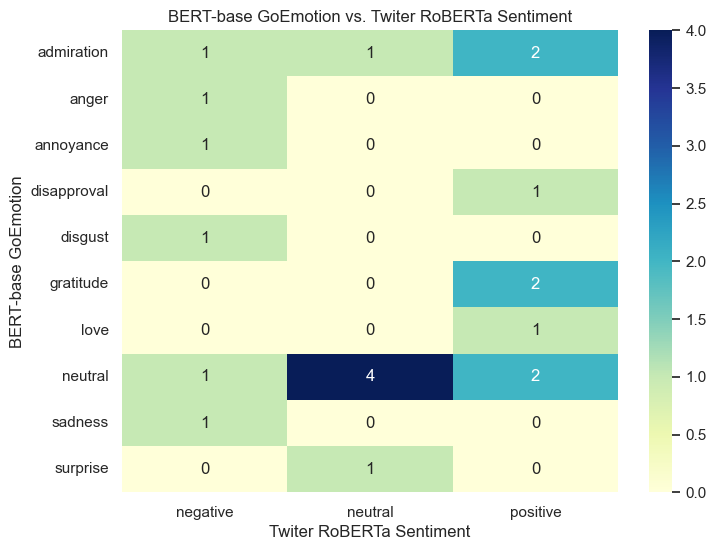

In [37]:
# Cross-tabulate NRC emotions and VADER sentiment
noisy_feedback = pd.crosstab(noisy_feedback['bert_ge_dominant_emotion'], noisy_feedback['roberta_sentiment'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ct_transformer, annot=True, fmt='d', cmap='YlGnBu')
plt.title('BERT-base GoEmotion vs. Twiter RoBERTa Sentiment')
plt.xlabel('Twiter RoBERTa Sentiment')
plt.ylabel('BERT-base GoEmotion')
plt.show()

In [55]:
noisy_feedback[['comments','nrc_dominant_emotion','bert_ge_dominant_emotion']]

,comments,nrc_dominant_emotion,bert_ge_dominant_emotion
0,Da staf was soooooo helpful 🙏💯 ty @branch_mgr!,joy,neutral
1,wOrSt exp evr!! 👎 nevr goin 2 dis bank again 🤬,trust,annoyance
2,"smooth process... bt d wait??? ughhhh, 1hr+ 😩",anticipation,curiosity
3,so 45 mins for ONE form?? lol wow. #efficient 🤡,anticipation,amusement
4,Xclnt svc 👏 issue solved fast af!! tysm!!,none,neutral
5,Rep wz rlly rude 😑 didn't even LISTEN!! #badexp,none,annoyance
6,not bad... not gr8 either. meh. 🤷,anger,disapproval
7,gotta love how 'pro' they r 🤣 sarcasm ON 🔥,joy,love
8,had 2 follow-up like 5 times 😤 finally got it done,anticipation,neutral
9,LOL they LOST my docs TWICE & said 'oops' 🤦,none,amusement
